# **Environmental sound classification**
## *Human Data Analytics - A.A. 2022/2023*


---



*Authors :*
*   Gianfrate Flavia
*   De Luca Chiara




## DATA IMPORT

Firstly we import the libraries and data needed for the ESC-10 project.
Next we create two structures that will be useful to keep track of filenames, to manipulate data and play audio.

In [ ]:
!pip install tensorflow-model-optimization
!pip uninstall numba
!pip install -U numba
# restart runtime

In [ ]:
import pandas as pd
import librosa
import numpy as np
import IPython.display as ipd
import pathlib
import glob, os, zipfile
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from scipy.io import wavfile
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras import backend as K
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Reshape, Dropout, Flatten, TimeDistributed
import tensorflow.keras.regularizers as rg
import seaborn as sns
from keras.utils.vis_utils import plot_model
from matplotlib.gridspec import SubplotSpec
import string
from tensorflow.keras.utils import to_categorical
import torch
import pickle
import tensorflow_model_optimization as tfmot
import tempfile
from sklearn.metrics import classification_report

In [ ]:
! git clone https://github.com/karolpiczak/ESC-50.git

Cloning into 'ESC-50'...
remote: Enumerating objects: 4193, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 4193 (delta 36), reused 28 (delta 12), pack-reused 4136
Receiving objects: 100% (4193/4193), 878.79 MiB | 15.34 MiB/s, done.
Resolving deltas: 100% (283/283), done.
Updating files: 100% (2011/2011), done.


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/")
%cd gdrive/MyDrive

Mounted at /content/gdrive/
/content/gdrive/MyDrive


In [ ]:
ecg_50_csv = pd.read_csv("/content/ESC-50/meta/esc50.csv")
print(ecg_50_csv.shape)
ecg_10_csv = ecg_50_csv[ecg_50_csv['esc10']==True]
print(ecg_10_csv.shape)

(2000, 7)
(400, 7)


In [ ]:
ecg_10_csv.head()

filename  fold  target        category  esc10  src_file take
0    1-100032-A-0.wav     1       0             dog   True    100032    A
14   1-110389-A-0.wav     1       0             dog   True    110389    A
24  1-116765-A-41.wav     1      41        chainsaw   True    116765    A
54   1-17150-A-12.wav     1      12  crackling_fire   True     17150    A
55  1-172649-A-40.wav     1      40      helicopter   True    172649    A

In [ ]:
filename_list = []
for i in ecg_10_csv['filename']:
  filename_list.append(i)

In [ ]:
audio_arrays = []
sounds = []
path = "/content/ESC-50/audio"
for filename in sorted(glob.glob(os.path.join(path, "*.wav"))):
  if pathlib.PurePath(filename).name in filename_list:
    y, sample_rate = librosa.load(filename)
    audio_arrays.append(y)
    sounds.append(filename)

## EXPLORATORY ANALYSIS AND PREPROCESSING

In this section we start from an exploratory analysis with some data integrity checks such as the one on the balance of the classes and then we can look some plots that will give us a first representation of how to visualize an audio.
Following the preprocessing part has the goal of creating a final data structure that can be inserted into the models.
The first step is the data augmentation: it is useful to increase the 400 original data through some transformations that will lead in our case to a dataset composed of 3600 observations.
Before proceeding to the modeling section, it is obviously important to proceed with the normalization of the data and the splitting into y and X.
In particular we will have two different X that depend on the type of approach with which we want to solve the classification.
A first X is represented by features obtained from the Mel-frequency cepstral coefficients while the second X consists of the pixels of the spectrogram images.





### Check presence of unbalanced data

In [ ]:
categories = list(set(ecg_10_csv['category']))
print(categories)

['helicopter', 'chainsaw', 'crackling_fire', 'sneezing', 'rain', 'rooster', 'clock_tick', 'sea_waves', 'crying_baby', 'dog']


['chainsaw' 'clock_tick' 'crackling_fire' 'crying_baby' 'dog' 'helicopter'
 'rain' 'rooster' 'sea_waves' 'sneezing'] [40 40 40 40 40 40 40 40 40 40]


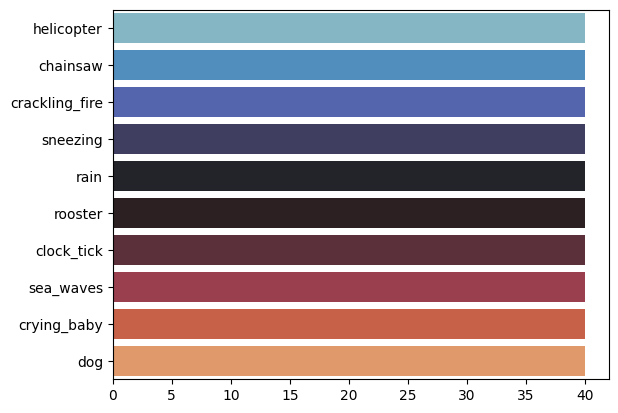

In [ ]:
unique, counts = np.unique(ecg_10_csv['category'], return_counts = True)
y_freq = counts
print(unique, counts)
sns.barplot(x=y_freq, y=categories, palette="icefire")
plt.savefig('/content/gdrive/MyDrive/ESC-10 material/balance_data.png')

### EDA

Now we want to explore the main properties of sounds. That's why we choose to generate three different plots: \


- **Time-Amplitude plot** (waveform, loudness of the sound) --> It could be seen as a simple raw sound plot. It is useful just to see how the sound goes over time.
- **Spectrogram** --> It is the behaviour of frequencies over time. On x axis, we can detect t, while y axis is for the spectrum of frequencies. Colors represent the intensity levels of the sound.
- **Chromatogram** --> It is the representation of sound pitches over time. Also in this case x axis is represented by time, while pitches are in the y axis.

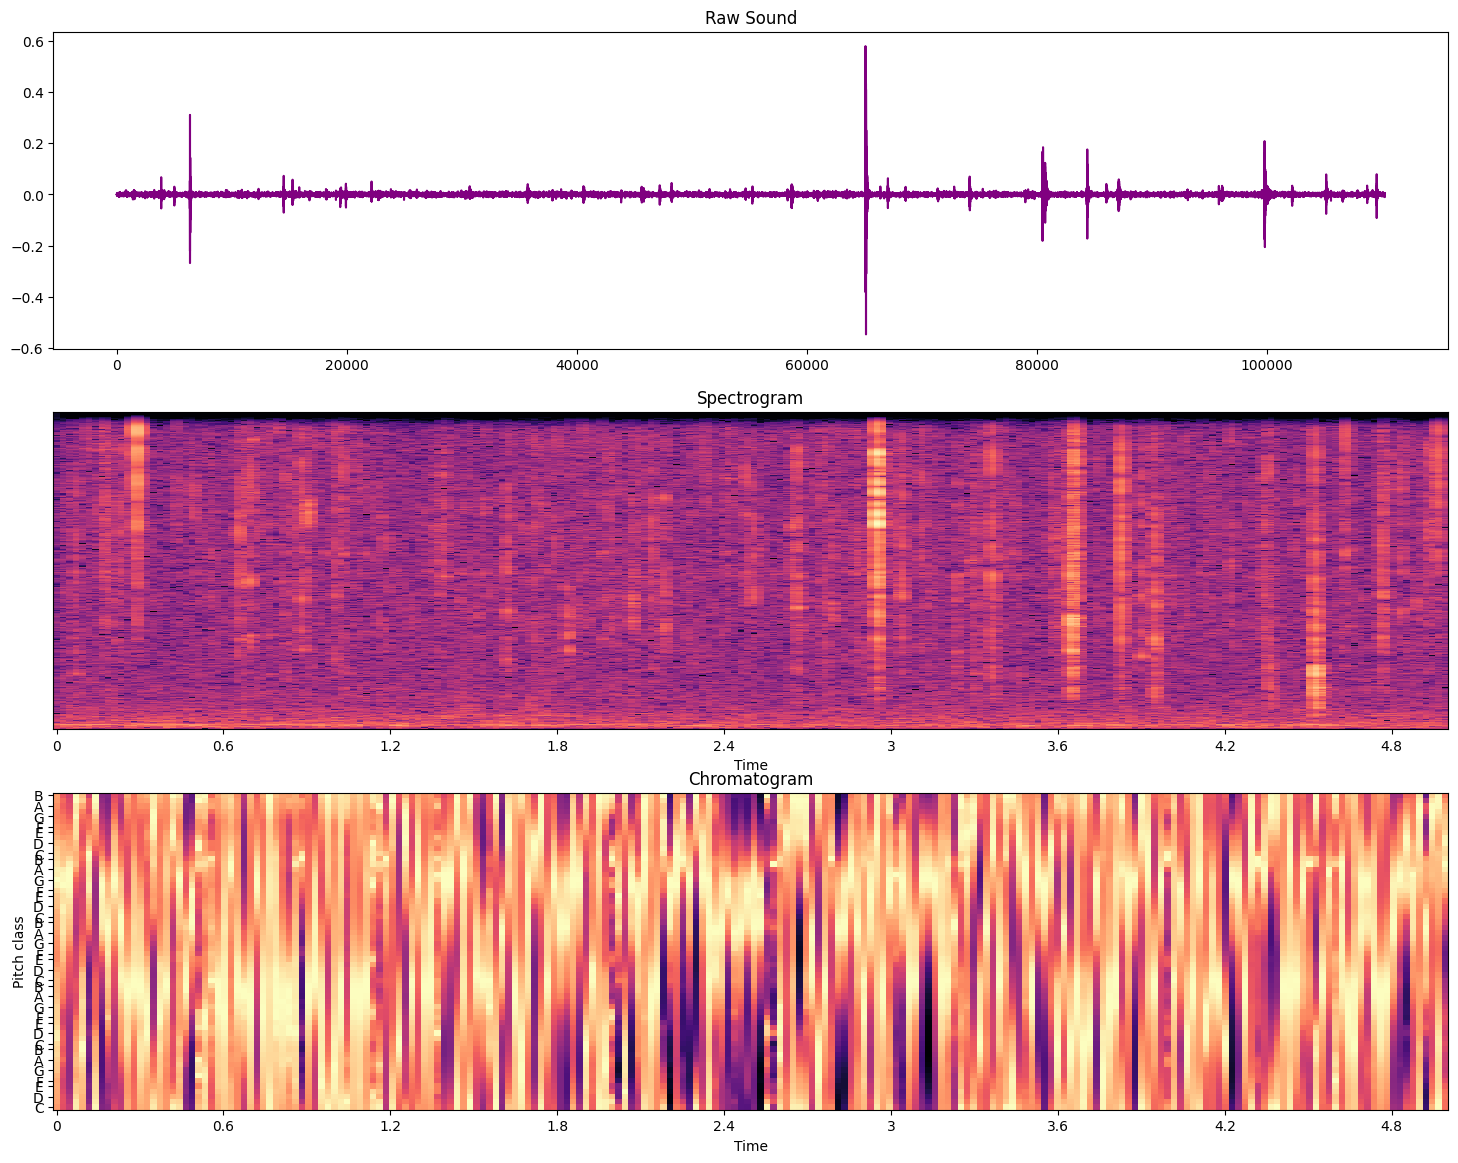

In [ ]:
y, sr = librosa.load(sounds[12])

S, phase = librosa.magphase(librosa.stft(y))
rms = librosa.feature.rms(S=S)

fig, ax = plt.subplots(figsize=(18, 14), nrows=3, sharex=False)
times = librosa.times_like(rms)
ax[0].plot(y, color = "purple")
ax[0].set(title='Raw Sound')

librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), x_axis='time', ax=ax[1])
ax[1].set(title='Spectrogram')

chromagram = librosa.feature.chroma_stft(y = audio_arrays[13], sr = sr,hop_length = 512, win_length = 1024, n_chroma = 60)
librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time')
ax[2].set(title='Chromatogram')

plt.savefig('/content/gdrive/MyDrive/ESC-10 material/EDA_first.png')

### Data Augmentation

We create some transformation functions and use them, even combined with each other, to augment the data.


1. Noise addiction
2. Time shifting
3. Time stretching
4. Pitch Shifting
5. Noise addiction + Time shifting
6. Time stretching + Pitch shifting
7. Noise addiction + Pitch shifting
8. Time stretching + Time shifting



In [ ]:
def noise_addiction(data, p):
  new_data = []
  wn = np.random.randn(len(data[0]))
  for i in sorted(range(len(data))):
    new_audio = data[i] + p*wn
    new_data.append(new_audio)
  return new_data

def time_shifting(data, q):
  new_data = []
  for i in sorted(range(len(data))):
    new_audio = np.roll(data[i], q)
    new_data.append(new_audio)
  return new_data

def time_stretching(data, s):
  new_data = []
  for i in sorted(range(len(data))):
    new_audio = librosa.effects.time_stretch(audio_arrays[i], rate = s)
    new_data.append(new_audio)
  return new_data

def pitch_shifting(data, r):
  new_data = []
  for i in sorted(range(len(data))):
    new_audio = librosa.effects.pitch_shift(audio_arrays[i],sr = r,n_steps=-5)
    new_data.append(new_audio)
  return new_data

In [ ]:
def data_augmentation(data):
  noise_add = noise_addiction(data, 0.05)
  time_shift = time_shifting(data, 50000)
  time_stretch = time_stretching(data, 2)
  pitch_shift = pitch_shifting(data, 5)
  noise_time_shift = noise_addiction(time_shift, 0.05)
  time_stretch_pitch_shift = pitch_shifting(time_stretch, 5)
  time_stretch_shift = time_stretching(time_shift, 2)
  noise_pitch_shift = noise_addiction(pitch_shift, 0.05)
  new_data = data + noise_add + time_shift + time_stretch + pitch_shift + noise_time_shift + time_stretch_pitch_shift + time_stretch_shift + noise_pitch_shift
  sample = (y - y.min()) / (y.max() - y.min())
  return new_data

In [ ]:
new_data = data_augmentation(audio_arrays)

In [ ]:
len(new_data[0])

110250

### Augmented data: plots and sounds of an audio after transformations

Here a sample audio is displayed through sound waves and played in its original form and after being transformed in the 8 different ways.

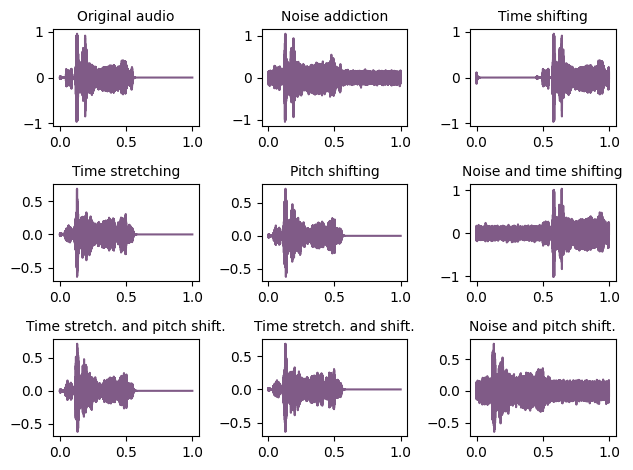

In [ ]:
fig, axs = plt.subplots(3, 3)
axs[0, 0].plot(np.linspace(0, 1, len(new_data[47])), new_data[47], color='xkcd:muted purple')
axs[0, 0].set_title("Original audio", fontsize=10)
axs[0, 1].plot(np.linspace(0, 1, len(new_data[447])), new_data[447], color='xkcd:muted purple')
axs[0, 1].set_title("Noise addiction", fontsize=10)
axs[0, 2].plot(np.linspace(0, 1, len(new_data[847])), new_data[847], color='xkcd:muted purple')
axs[0, 2].set_title("Time shifting", fontsize=10)
axs[1, 0].plot(np.linspace(0, 1, len(new_data[1247])), new_data[1247], color='xkcd:muted purple')
axs[1, 0].set_title("Time stretching", fontsize=10)
axs[1, 1].plot(np.linspace(0, 1, len(new_data[1647])), new_data[1647], color='xkcd:muted purple')
axs[1, 1].set_title("Pitch shifting", fontsize=10)
axs[1, 2].plot(np.linspace(0, 1, len(new_data[2047])), new_data[2047], color='xkcd:muted purple')
axs[1, 2].set_title("Noise and time shifting", fontsize=10)
axs[2, 0].plot(np.linspace(0, 1, len(new_data[2447])), new_data[2447], color='xkcd:muted purple')
axs[2, 0].set_title("Time stretch. and pitch shift.", fontsize=10)
axs[2, 1].plot(np.linspace(0, 1, len(new_data[2847])), new_data[2847], color='xkcd:muted purple')
axs[2, 1].set_title("Time stretch. and shift.", fontsize=10)
axs[2, 2].plot(np.linspace(0, 1, len(new_data[3247])), new_data[3247], color='xkcd:muted purple')
axs[2, 2].set_title("Noise and pitch shift.", fontsize=10)
fig.tight_layout()
plt.savefig('/content/gdrive/MyDrive/ESC-10 material/augmented_data.png')

In [ ]:
# original audio
ipd.Audio(new_data[47], rate=sample_rate)

In [ ]:
# noise addiction
ipd.Audio(new_data[447], rate=sample_rate)

In [ ]:
# time shifting
ipd.Audio(new_data[847], rate=sample_rate)

In [ ]:
# time stretching
ipd.Audio(new_data[1247], rate=sample_rate)

In [ ]:
# pitch shifting
ipd.Audio(new_data[1647], rate=sample_rate)

In [ ]:
# noise addiction and time shifting
ipd.Audio(new_data[2047], rate=sample_rate)

In [ ]:
# time stretching and pitch shifting
ipd.Audio(new_data[2447], rate=sample_rate)

In [ ]:
# time shifting and time stretching
ipd.Audio(new_data[2847], rate=sample_rate)

In [ ]:
# noise addiction and pitch shifting
ipd.Audio(new_data[3247], rate=sample_rate)

### Normalization

In [ ]:
def normalize_data(data):
  new_data = []
  for i in data:
    sample = (i - i.min()) / (i.max() - i.min())
    new_data.append(sample)
  return new_data

In [ ]:
new_data = normalize_data(new_data)

In [ ]:
#file_path0 = '/content/gdrive/MyDrive/ESC-10 material/audio_data.npy'

#np.save(file_path0, new_data)

### Target variable y

In [ ]:
ecg_10 = ecg_10_csv["category"]
labels = []

for j in range (1,10):
  for i in ecg_10:
    labels.append(i)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)
y_cat = tf.keras.utils.to_categorical(y)
print(y.shape, y_cat.shape)

# to keep track of original labels
mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(mapping)

(3600,) (3600, 10)
{'chainsaw': 0, 'clock_tick': 1, 'crackling_fire': 2, 'crying_baby': 3, 'dog': 4, 'helicopter': 5, 'rain': 6, 'rooster': 7, 'sea_waves': 8, 'sneezing': 9}


### Differences between classes

This plot represents the frequency content of an audio signal through melspectrograms and mfccs and the amplitude changes through the chromogram of an example for each class.

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


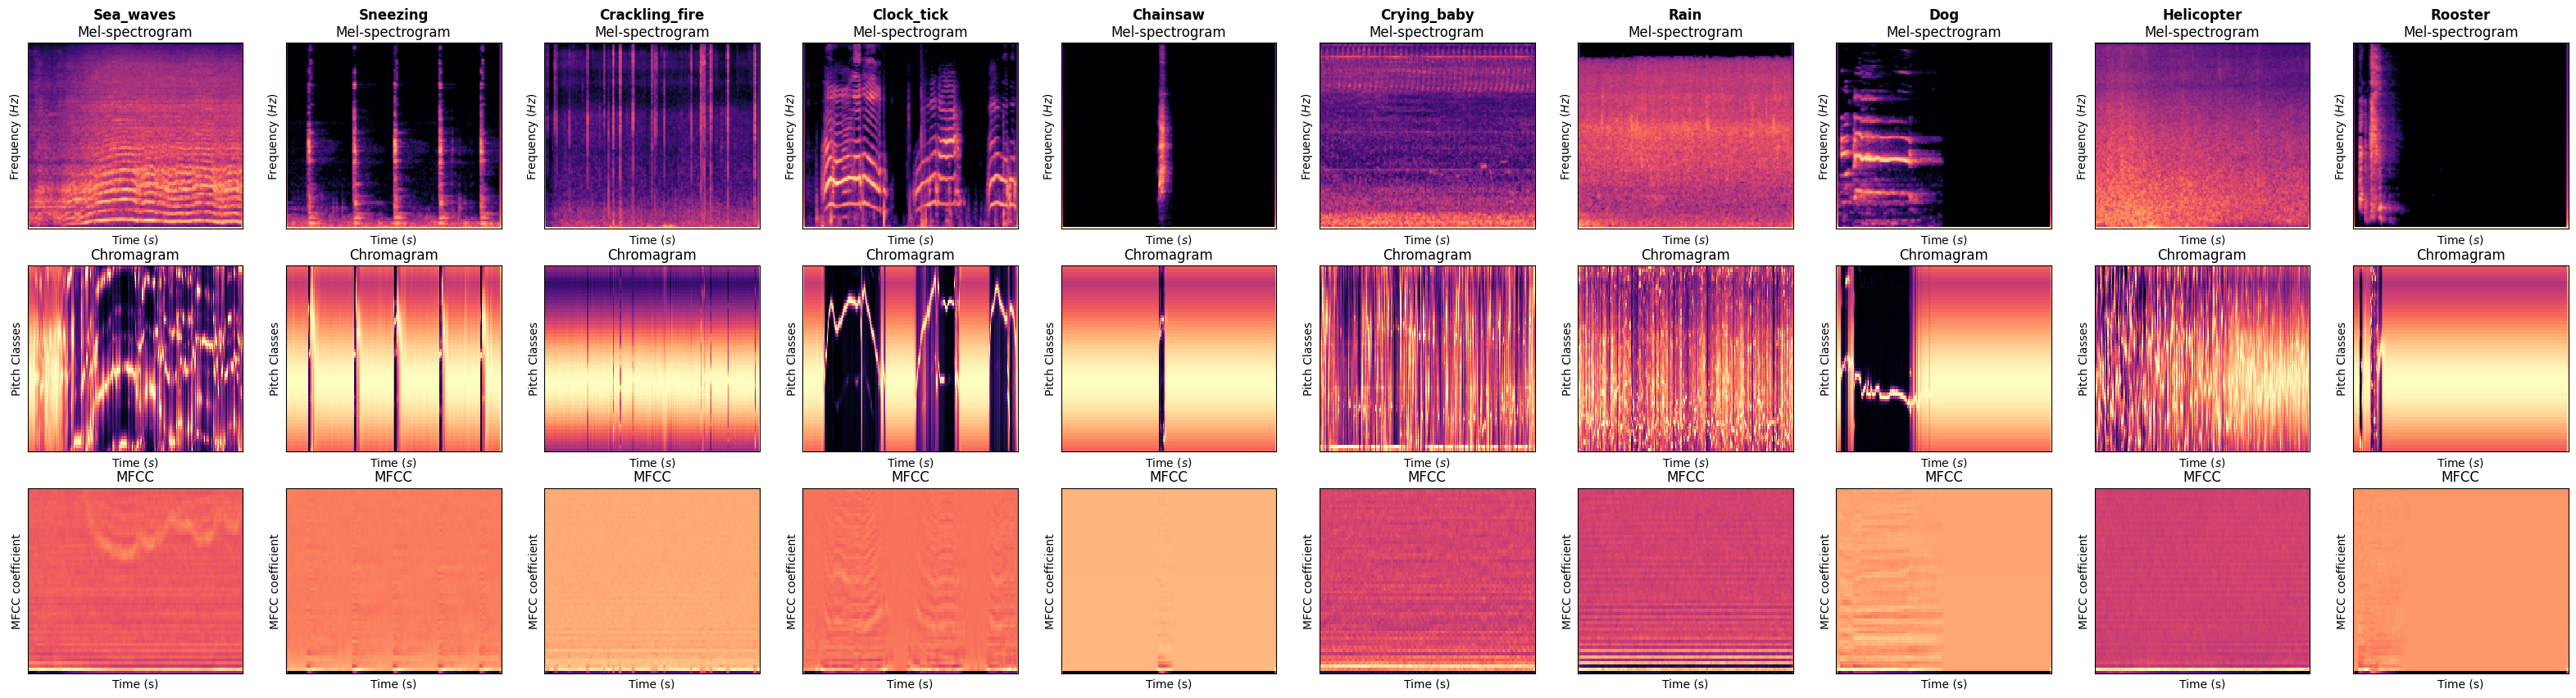

In [ ]:
df = pd.DataFrame({'X' : new_data, 'y' : y})

first_obs = df.groupby('y').first()

fig, ax = plt.subplots(3, 10, figsize=(40,10))
grid = plt.GridSpec(3, 10)

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    row = fig.add_subplot(grid)
    row.set_title(f'{title}\n', fontweight='semibold')
    row.set_frame_on(False)
    row.axis('off')

for k in range(first_obs.shape[0]):
  create_subtitle(fig, grid[::, k], string.capwords(categories[k]))

for i in range(first_obs.shape[0]):
  audio_array = np.stack(first_obs.iloc[i].to_numpy())[0]
  librosa.display.specshow(librosa.power_to_db(librosa.feature.melspectrogram(y=audio_array, sr = sample_rate, n_mels = 128)), ax=ax[0,i], cmap = "magma")
  ax[0,i].set_xlabel("Time $(s)$")
  ax[0,i].set_ylabel("Frequency $(Hz)$")
  ax[0,i].set_title("Mel-spectrogram")
  librosa.display.specshow(librosa.feature.chroma_stft(y=audio_array, sr=sample_rate, hop_length=512, win_length=1024, n_chroma=60), cmap="magma", ax=ax[1,i])
  ax[1,i].set_xlabel("Time $(s)$")
  ax[1,i].set_ylabel("Pitch Classes")
  ax[1,i].set_title("Chromagram")
  librosa.display.specshow(librosa.feature.mfcc(y=audio_array, sr=sample_rate, n_mfcc=60, hop_length=512), cmap="magma", ax=ax[2,i])
  ax[2,i].set_xlabel("Time (s)")
  ax[2,i].set_ylabel("MFCC coefficient")
  ax[2,i].set_title("MFCC")

fig.savefig('/content/gdrive/MyDrive/ESC-10 material/full_figure.png')

### MFCCS - Mel-frequency cepstral coefficients

The first X is composed of the MFCCs, which consist of compact numerical descriptions of the spectral content of an audio signal.
After trying a few configurations, the best representation of the ESC-10 data is as follows.

In [ ]:
def mfccs_function(data):
  extracted_features = []
  for i in sorted(range(len(data))):
    melspectrogram = librosa.feature.melspectrogram(y = data[i], sr = sample_rate)
    logamplitude = librosa.amplitude_to_db(melspectrogram)
    # hop_length is the default spacing between frames
    # n_mfcc is the number of features
    mfccs = librosa.feature.mfcc(S = logamplitude, n_mfcc = 60, hop_length = 512, win_length = 1024)
    new_chromagram = librosa.feature.chroma_stft(y = data[i], sr = sample_rate, hop_length = 512, win_length = 1024, n_chroma = 60)
    new_delta = librosa.feature.delta(mfccs)
    new_instance = np.dstack((mfccs, new_chromagram, new_delta))
    extracted_features.append(new_instance)
  return extracted_features

In [ ]:
X = mfccs_function(new_data)
print(X[0].shape)

(60, 216, 3)


After the augmentation, the speeded up audios are shorter, with this function we resize those data in such a way to have the same 5 seconds length for all audios.



In [ ]:
def fix_function(data):
  new_X = []
  for i in sorted(range(len(data))):
      if data[i].shape == (60, 108, 3):
        new_X.append(np.concatenate((data[i], data[i]), axis=1))
      else:
        new_X.append(data[i])
  X = np.array(new_X)
  return X

In [ ]:
X = fix_function(X)

### Spectrograms

#### Create Spectrograms Images and save on a drive folder

In [ ]:
"""
from scipy.io import wavfile

directory = 'ESC_10_sounds'
if not os.path.exists(directory):
    os.makedirs(directory)

for i, audio_array in enumerate(new_data):
    filename = os.path.join(directory, f'{i}.wav')
    wavfile.write(filename, sample_rate, audio_array)
"""

In [ ]:
"""
def create_spectrogram(audio_file, image_file):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    y, sr = librosa.load(audio_file)
    S, phase = librosa.magphase(librosa.stft(y))
    librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), x_axis='time')

    fig.savefig(image_file)
    plt.close(fig)

def create_pngs_from_wavs(input_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    dir = os.listdir(input_path)

    for i, file in enumerate(dir):
        input_file = os.path.join(input_path, file)
        output_file = os.path.join(output_path, file.replace('.wav', '.png'))
        create_spectrogram(input_file, output_file)


create_pngs_from_wavs('/content/ESC_10_sounds', '/content/Spectrograms')
"""

In [ ]:
"""
from google.colab import files

dir_to_zip = 'Spectrograms' #@param {type: "string"}
output_filename = 'spectrogram.zip' #@param {type: "string"}
delete_dir_after_download = "No"  #@param ['Yes', 'No']

os.system( "zip -r {} {}".format( output_filename , dir_to_zip ) )

if delete_dir_after_download == "Yes":
    os.system( "rm -r {}".format( dir_to_zip ) )

files.download( output_filename )
"""

#### Import Spectrogram Images from Drive

In [ ]:
import shutil
shutil.copy("/content/gdrive/MyDrive/spectrogram.zip", "/content")

'/content/spectrogram.zip'

In [ ]:
!unzip /content/spectrogram.zip -d /content;

Archive:  /content/spectrogram.zip
replace /content/Spectrograms/1173.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#### Spectrogram data preparation

In [ ]:
from keras.preprocessing import image
import keras.utils as image

def load_images_from_path(path):
    images = []

    for file in sorted(os.listdir(path), key=lambda x: int(x.split('.')[0])):
    #for file in os.listdir(path):
        images.append(image.img_to_array(image.load_img(os.path.join(path, file), target_size=(224, 224, 3))))

    return images

x1 = []

images = load_images_from_path('/content/Spectrograms')

x1 += images

In [ ]:
X_spec = np.array(x1) / 255

## MODELS

In [ ]:
import resource

# Time of inference
def measure_inference_time(model, data):
    start_time = time.time()
    model.predict(data)
    end_time = time.time()

    inference_time = end_time - start_time
    return inference_time

# Size of gzipped model, in bytes
def get_gzipped_model_size(file):

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [ ]:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [ ]:
from keras.initializers import glorot_uniform
seed_value = 64
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

### Models with MFCCs

#### Preparation

In [ ]:
val_size  = .15
test_size = .15

X_train, X_test_val, y_cat_train, y_cat_test_val = train_test_split(X, y_cat, test_size=val_size+test_size, random_state=42, stratify=y_cat)
X_val, X_test, y_cat_val, y_cat_test = train_test_split(X_test_val, y_cat_test_val, test_size=test_size/(test_size+val_size), random_state=42, stratify=y_cat_test_val)
print(X_train.shape, X_test.shape, X_val.shape, y_cat_train.shape, y_cat_test.shape,  y_cat_val.shape)

(2520, 60, 216, 3) (540, 60, 216, 3) (540, 60, 216, 3) (2520, 10) (540, 10) (540, 10)


In [ ]:
file_path1 = '/content/gdrive/MyDrive/ESC-10 material/X_test_cnn_mfcc.npy'
file_path2 = '/content/gdrive/MyDrive/ESC-10 material/y_test_cnn_mfcc.npy'
file_path3 = '/content/gdrive/MyDrive/ESC-10 material/X_train_cnn_mfcc.npy'
file_path4 = '/content/gdrive/MyDrive/ESC-10 material/y_train_cnn_mfcc.npy'
file_path5 = '/content/gdrive/MyDrive/ESC-10 material/X_val_cnn_mfcc.npy'
file_path6 = '/content/gdrive/MyDrive/ESC-10 material/y_val_cnn_mfcc.npy'

np.save(file_path1, X_test)
np.save(file_path2, y_cat_test)
np.save(file_path3, X_train)
np.save(file_path4, y_cat_train)
np.save(file_path5, X_val)
np.save(file_path6, y_cat_val)

In [ ]:
#Per la RNN
X_train_rnn = np.transpose(np.squeeze(X_train[..., :1]), (0, 2, 1))
X_val_rnn = np.transpose(np.squeeze(X_val[..., :1]), (0, 2, 1))
X_test_rnn = np.transpose(np.squeeze(X_test[..., :1]), (0, 2, 1))
print(X_train_rnn.shape, X_val_rnn.shape, X_test_rnn.shape)

(2520, 216, 60) (540, 216, 60) (540, 216, 60)


In [ ]:
y_train = np.argmax(y_cat_train, axis = 1)
y_val = np.argmax(y_cat_val, axis = 1)
y_test = np.argmax(y_cat_test, axis = 1)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    mode='min',
    restore_best_weights=True
)

#### CNN - Convolutional Neural Networks

In [ ]:
model1 =  Sequential([
                          layers.Conv2D(32, (3,3), activation = 'relu', padding='valid', input_shape = X_train.shape[1:], strides=(2, 2), kernel_initializer=glorot_uniform(seed=seed_value)),
                          layers.MaxPooling2D(2, padding='valid'),
                          layers.Conv2D(64, (3,3), activation='relu', padding='valid'),
                          layers.MaxPooling2D(2, padding='valid'),
                          layers.Dropout(0.2),
                          layers.Conv2D(128, (2,2), activation='relu', padding='valid', kernel_regularizer=rg.l1(0.01)),
                          layers.MaxPooling2D(2, padding='valid'),
                          layers.Flatten(),
                          layers.Dense(128, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(10, activation = 'softmax')
])

model1.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'acc')
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 29, 107, 32)       896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 53, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 12, 51, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 6, 25, 64)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 6, 25, 64)         0         
                                                                 
 conv2d_11 (Conv2D)          (None, 5, 24, 128)       

In [ ]:
# Train model
history1 = model1.fit(X_train, y_cat_train, batch_size=64, epochs=100, validation_data=(X_val, y_cat_val), callbacks=[early_stopping], shuffle=False)

# Evaluate model
score1 = model1.evaluate(X_val, y_cat_val, verbose=0)

# Save model
model1.save('/content/gdrive/MyDrive/models/cnn_mfcc.h5')
_, keras_file1 = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model1, keras_file1, include_optimizer=False)
print('Saved baseline model to:', keras_file1)

Epoch 1/100
40/40 [==============================] - 12s 22ms/step - loss: 14.0587 - acc: 0.2917 - val_loss: 9.7520 - val_acc: 0.5407
Epoch 2/100
40/40 [==============================] - 0s 10ms/step - loss: 7.3951 - acc: 0.5492 - val_loss: 4.9981 - val_acc: 0.7185
Epoch 3/100
40/40 [==============================] - 0s 10ms/step - loss: 3.9801 - acc: 0.6671 - val_loss: 2.9242 - val_acc: 0.7500
Epoch 4/100
40/40 [==============================] - 0s 10ms/step - loss: 2.4962 - acc: 0.7056 - val_loss: 1.8449 - val_acc: 0.8278
Epoch 5/100
40/40 [==============================] - 0s 10ms/step - loss: 1.7145 - acc: 0.7440 - val_loss: 1.3222 - val_acc: 0.8315
Epoch 6/100
40/40 [==============================] - 0s 10ms/step - loss: 1.3155 - acc: 0.7639 - val_loss: 1.0423 - val_acc: 0.8278
Epoch 7/100
40/40 [==============================] - 0s 10ms/step - loss: 1.0436 - acc: 0.7940 - val_loss: 0.8423 - val_acc: 0.8537
Epoch 8/100
40/40 [==============================] - 0s 10ms/step - loss: 

<ipython-input-49-d30e1d7bec7c>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs1, train_acc1, 'b', label='Training accuracy', color='darkmagenta')
<ipython-input-49-d30e1d7bec7c>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs1, val_acc1, 'r', label='Validation accuracy', color='tab:orange')


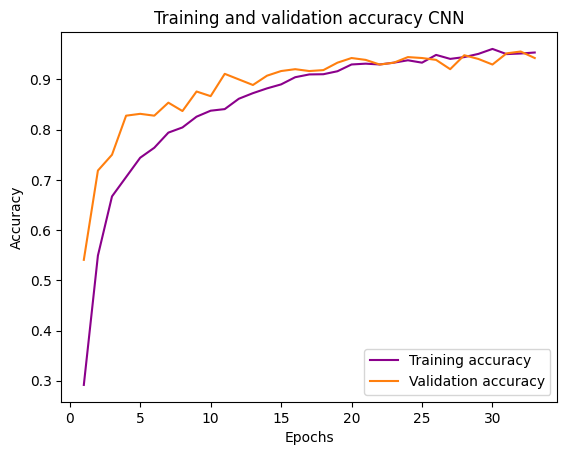

<ipython-input-49-d30e1d7bec7c>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs1, train_loss1, 'b', label='Training loss', color='darkmagenta')
<ipython-input-49-d30e1d7bec7c>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs1, val_loss1, 'r', label='Validation loss', color='tab:orange')


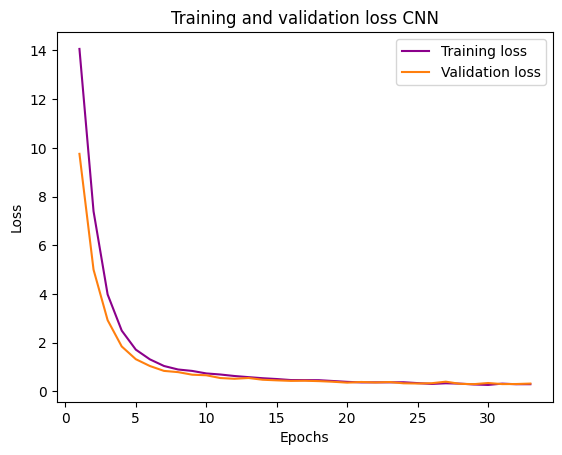

In [ ]:
train_acc1 = history1.history['acc']
train_loss1 = history1.history['loss']
val_acc1 = history1.history['val_acc']
val_loss1 = history1.history['val_loss']

epochs1 = range(1, len(train_acc1) + 1)

plt.plot(epochs1, train_acc1, 'b', label='Training accuracy', color='darkmagenta')
plt.plot(epochs1, val_acc1, 'r', label='Validation accuracy', color='tab:orange')
plt.title('Training and validation accuracy CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/gdrive/MyDrive/ESC-10 material/acc_function_CNN_mfcc.png')
plt.show()

plt.plot(epochs1, train_loss1, 'b', label='Training loss', color='darkmagenta')
plt.plot(epochs1, val_loss1, 'r', label='Validation loss', color='tab:orange')
plt.title('Training and validation loss CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/gdrive/MyDrive/ESC-10 material/loss_function_CNN_mfcc.png')
plt.show()

Check accuracy on test set and all errors of the model

In [ ]:
# Predict classes for test data
y_pred1 = model1.predict(X_test)

# Convert in the same form
y_pred1 = np.argmax(y_pred1, axis=1)

# Compare predictions to true labels
misclassified_indices = np.where(y_pred1 != y_test)[0]
print(misclassified_indices)

# evaluate the keras model
_, accuracy1 = model1.evaluate(X_test, y_cat_test)
initial_inference_time_1 = measure_inference_time(model1, X_test)

print('Accuracy: %.2f' % (accuracy1*100))
print("Time of inference:", round(initial_inference_time_1, 2))
print("Size of gzipped CNN with MFCC model: %.2f KB" % (get_gzipped_model_size(keras_file1)/ 1024))

17/17 [==============================] - 0s 3ms/step
[  2   6  24  32  67 137 146 153 173 199 224 242 244 259 274 292 350 366
 380 391 397 404 414 427 431 447 455 461 463 465 504 524]
17/17 [==============================] - 0s 3ms/step
Accuracy: 94.07
Time of inference: 0.28
Size of gzipped CNN with MFCC model: 1622.69 KB


In [ ]:
print(classification_report(y_test, y_pred1, target_names=mapping.keys()))

                precision    recall  f1-score   support

      chainsaw       1.00      0.96      0.98        54
    clock_tick       0.94      0.91      0.92        54
crackling_fire       0.91      0.91      0.91        54
   crying_baby       0.93      1.00      0.96        54
           dog       0.98      0.93      0.95        54
    helicopter       0.82      0.94      0.88        54
          rain       0.93      0.80      0.86        54
       rooster       1.00      1.00      1.00        54
     sea_waves       0.95      0.98      0.96        54
      sneezing       0.96      0.98      0.97        54

      accuracy                           0.94       540
     macro avg       0.94      0.94      0.94       540
  weighted avg       0.94      0.94      0.94       540



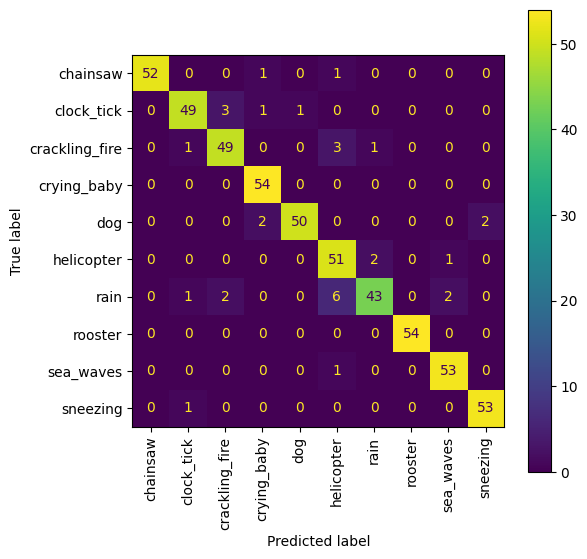

<Figure size 640x480 with 0 Axes>

In [ ]:
r_cnn = confusion_matrix(y_test, y_pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=r_cnn, display_labels=mapping)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax)
ax.set_xticklabels(mapping.keys(), rotation='vertical')
plt.show()
plt.savefig('/content/gdrive/MyDrive/ESC-10 material/cnn_mfcc_conf_mat.png')
np.save('/content/gdrive/MyDrive/ESC-10 material/cm_cnn_mfcc.npy', r_cnn)

Check a particular error and find sound

In [ ]:
# indexes of a particular error
misclassifications = np.where((y_pred1 == 5) & (y_test == 6))[0]
print(misclassifications)

[  2  67 274 350 463 465]


In [ ]:
# listen the audio classified wrong
# the model mistakes a helicopter for rain
miscl = X_test[2]
idx = np.where(np.all(X == miscl, axis=(1, 2)))[0][0]
ipd.Audio(new_data[idx], rate=sample_rate)

#### LSTM - Long short-term memory

In [ ]:
model3 =  Sequential([
                          layers.LSTM(units=256, input_shape=X_train_rnn.shape[1:]),
                          layers.Dropout(0.2),
                          layers.Dense(128, activation='relu', kernel_regularizer=rg.l1(0.001)),
                          layers.Dropout(0.2),
                          layers.Dense(64, activation='relu'),
                          layers.Dropout(0.2),
                          layers.Dense(10, activation = 'softmax')
])

model3.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics = 'acc')
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               324608    
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 10)               

In [ ]:
# Train model
history3 = model3.fit(X_train_rnn, y_cat_train, batch_size=128, epochs=100, validation_data=(X_val_rnn, y_cat_val), callbacks=[early_stopping], shuffle=False)

# Evaluate model
score3 = model3.evaluate(X_val_rnn, y_cat_val, verbose=0)

# Save model
model3.save('/content/gdrive/MyDrive/models/rnn_mfcc.h5')
_, keras_file3 = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model3, keras_file3, include_optimizer=False)
print('Saved baseline model to:', keras_file3)

Epoch 1/100
20/20 [==============================] - 5s 55ms/step - loss: 4.0654 - acc: 0.2179 - val_loss: 3.5965 - val_acc: 0.3444
Epoch 2/100
20/20 [==============================] - 1s 29ms/step - loss: 3.3947 - acc: 0.3266 - val_loss: 2.9460 - val_acc: 0.4852
Epoch 3/100
20/20 [==============================] - 0s 24ms/step - loss: 2.8558 - acc: 0.4278 - val_loss: 2.5014 - val_acc: 0.5444
Epoch 4/100
20/20 [==============================] - 0s 23ms/step - loss: 2.4376 - acc: 0.5171 - val_loss: 2.1589 - val_acc: 0.6500
Epoch 5/100
20/20 [==============================] - 0s 24ms/step - loss: 2.1169 - acc: 0.5730 - val_loss: 1.8282 - val_acc: 0.6963
Epoch 6/100
20/20 [==============================] - 0s 24ms/step - loss: 1.8555 - acc: 0.6528 - val_loss: 1.5969 - val_acc: 0.7537
Epoch 7/100
20/20 [==============================] - 0s 24ms/step - loss: 1.6585 - acc: 0.6817 - val_loss: 1.4665 - val_acc: 0.7741
Epoch 8/100
20/20 [==============================] - 0s 23ms/step - loss: 1.

<ipython-input-75-188aaa5bde2b>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs3, train_acc3, 'b', label='Training accuracy', color='darkmagenta')
<ipython-input-75-188aaa5bde2b>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs3, val_acc3, 'r', label='Validation accuracy', color='tab:orange')


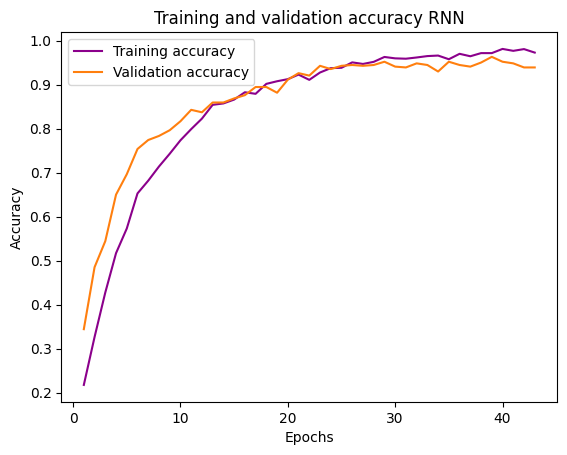

<ipython-input-75-188aaa5bde2b>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs3, train_loss3, 'b', label='Training loss', color='darkmagenta')
<ipython-input-75-188aaa5bde2b>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs3, val_loss3, 'r', label='Validation loss', color='tab:orange')


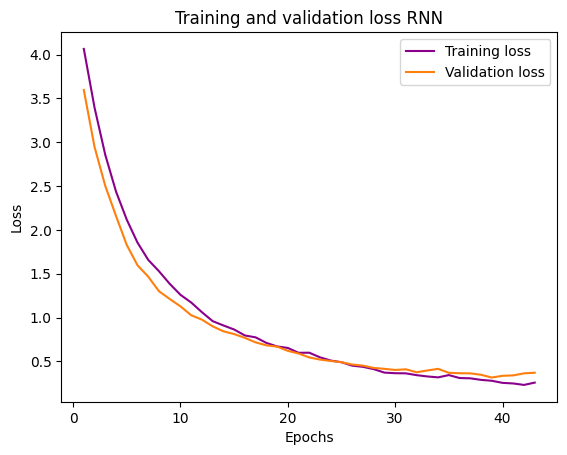

In [ ]:
train_acc3 = history3.history['acc']
train_loss3 = history3.history['loss']
val_acc3 = history3.history['val_acc']
val_loss3 = history3.history['val_loss']

epochs3 = range(1, len(train_acc3) + 1)

plt.plot(epochs3, train_acc3, 'b', label='Training accuracy', color='darkmagenta')
plt.plot(epochs3, val_acc3, 'r', label='Validation accuracy', color='tab:orange')
plt.title('Training and validation accuracy RNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/gdrive/MyDrive/ESC-10 material/acc_function_RNN_mfcc.png')
plt.show()

plt.plot(epochs3, train_loss3, 'b', label='Training loss', color='darkmagenta')
plt.plot(epochs3, val_loss3, 'r', label='Validation loss', color='tab:orange')
plt.title('Training and validation loss RNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/gdrive/MyDrive/ESC-10 material/loss_function_RNN_mfcc.png')
plt.show()

Check accuracy on test set and all errors of the model

In [ ]:
# Predict classes for test data
y_pred3 = model3.predict(X_test_rnn)

# Convert in the same form
y_pred3 = np.argmax(y_pred3, axis=1)

# Compare predictions to true labels
misclassified_indices = np.where(y_pred3 != y_test)[0]
print(misclassified_indices)

# evaluate the keras model
_, accuracy3 = model3.evaluate(X_test_rnn, y_cat_test)
initial_inference_time_3 = measure_inference_time(model3, X_test_rnn)

print('Accuracy: %.2f' % (accuracy3*100))
print("Time of inference:", round(initial_inference_time_3, 2))
print("Size of gzipped RNN with MFCC model: %.2f KB" % (get_gzipped_model_size(keras_file3)/ 1024))

17/17 [==============================] - 0s 6ms/step
[ 13  33  35  67 118 125 173 204 241 255 274 369 446 447 455 465 475 488
 512 519 520 524]
17/17 [==============================] - 0s 6ms/step
Accuracy: 95.93
Time of inference: 0.2
Size of gzipped RNN with MFCC model: 1334.07 KB


In [ ]:
print(classification_report(y_test, y_pred3, target_names=mapping.keys()))

                precision    recall  f1-score   support

      chainsaw       1.00      0.98      0.99        54
    clock_tick       0.88      0.94      0.91        54
crackling_fire       0.91      0.89      0.90        54
   crying_baby       1.00      1.00      1.00        54
           dog       0.96      0.96      0.96        54
    helicopter       0.96      0.98      0.97        54
          rain       0.94      0.93      0.93        54
       rooster       1.00      1.00      1.00        54
     sea_waves       0.95      0.96      0.95        54
      sneezing       1.00      0.94      0.97        54

      accuracy                           0.96       540
     macro avg       0.96      0.96      0.96       540
  weighted avg       0.96      0.96      0.96       540



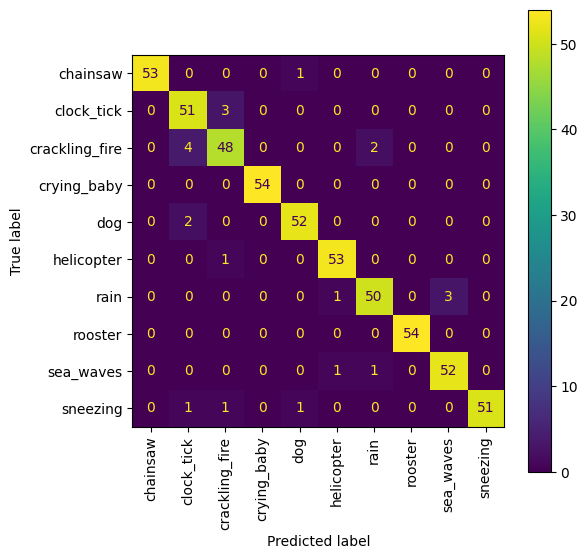

<Figure size 640x480 with 0 Axes>

In [ ]:
r_rnn = confusion_matrix(y_test, y_pred3)
disp = ConfusionMatrixDisplay(confusion_matrix=r_rnn, display_labels=mapping)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax)
ax.set_xticklabels(mapping.keys(), rotation='vertical')
plt.show()
plt.savefig('/content/gdrive/MyDrive/ESC-10 material/rnn_mfcc_conf_mat.png')
np.save('/content/gdrive/MyDrive/ESC-10 material/cm_rnn_mfcc.npy', r_rnn)

Check a particular error and find sound

In [ ]:
# indexes of a particular error
misclassifications = np.where((y_pred3 == 1) & (y_test == 2))[0]
print(misclassifications)

[ 13 369 446 455]


In [ ]:
# listen the audio classified wrong
# the model mistakes this crackling fire for clock tick
miscl = X_test[455]
idx = np.where(np.all(X == miscl, axis=(1, 2)))[0][0]
ipd.Audio(new_data[idx], rate=sample_rate)

#### CRNN - Convolutional recurrent neural network

In [ ]:
model2 =  Sequential([
                          layers.Conv2D(32, (4,4),activation = 'relu',padding='valid', input_shape=X_train.shape[1:], strides=(2,2), kernel_initializer=glorot_uniform(seed=seed_value)),
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Dropout(0.3),
                          layers.Conv2D(128, (3,3), activation='relu',padding='valid', strides=(2,2), kernel_regularizer=rg.l1(0.001)),
                          layers.Dropout(0.2),
                          layers.Conv2D(64, (2,2), activation='relu',padding='valid', kernel_regularizer=rg.l1(0.001)),
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Dropout(0.3),
                          layers.TimeDistributed(Flatten()),
                          layers.LSTM(64, return_sequences=False),
                          layers.Dropout(0.3),
                          layers.Dense(10, activation = 'softmax')
])

model2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'acc')
model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 29, 107, 32)       1568      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 15, 54, 32)       0         
 g2D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 15, 54, 32)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 7, 26, 128)        36992     
                                                                 
 dropout_20 (Dropout)        (None, 7, 26, 128)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 6, 25, 64)         32832     
                                                      

In [ ]:
# Train model
history2 = model2.fit(X_train, y_cat_train, batch_size=64, epochs=100, validation_data=(X_val, y_cat_val), callbacks=[early_stopping], shuffle=False)

# Evaluate model
score2 = model2.evaluate(X_val, y_cat_val, verbose=0)

# Save model
model2.save('/content/gdrive/MyDrive/models/crnn_mfcc.h5')
_, keras_file2 = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model2, keras_file2, include_optimizer=False)
print('Saved baseline model to:', keras_file2)

Epoch 1/100
40/40 [==============================] - 4s 33ms/step - loss: 4.5531 - acc: 0.1710 - val_loss: 3.8973 - val_acc: 0.3278
Epoch 2/100
40/40 [==============================] - 1s 13ms/step - loss: 3.4999 - acc: 0.3290 - val_loss: 2.9137 - val_acc: 0.5074
Epoch 3/100
40/40 [==============================] - 0s 12ms/step - loss: 2.6855 - acc: 0.4567 - val_loss: 2.2731 - val_acc: 0.5648
Epoch 4/100
40/40 [==============================] - 0s 12ms/step - loss: 2.1417 - acc: 0.5536 - val_loss: 1.7866 - val_acc: 0.6685
Epoch 5/100
40/40 [==============================] - 0s 11ms/step - loss: 1.7824 - acc: 0.6139 - val_loss: 1.5069 - val_acc: 0.7296
Epoch 6/100
40/40 [==============================] - 1s 13ms/step - loss: 1.5063 - acc: 0.6893 - val_loss: 1.2873 - val_acc: 0.7630
Epoch 7/100
40/40 [==============================] - 1s 14ms/step - loss: 1.3411 - acc: 0.7032 - val_loss: 1.1243 - val_acc: 0.8037
Epoch 8/100
40/40 [==============================] - 0s 12ms/step - loss: 1.

<ipython-input-93-93eafaba5ee3>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs2, train_acc2, 'b', label='Training accuracy', color='darkmagenta')
<ipython-input-93-93eafaba5ee3>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs2, val_acc2, 'r', label='Validation accuracy', color='tab:orange')


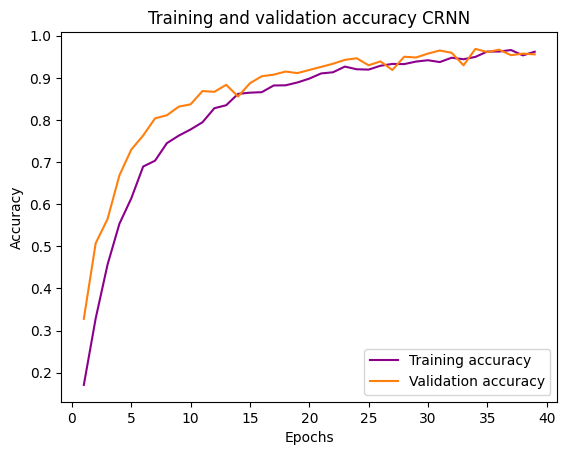

<ipython-input-93-93eafaba5ee3>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs2, train_loss2, 'b', label='Training loss', color='darkmagenta')
<ipython-input-93-93eafaba5ee3>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs2, val_loss2, 'r', label='Validation loss', color='tab:orange')


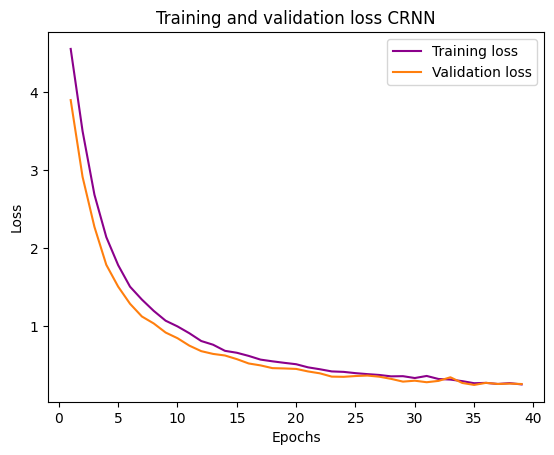

In [ ]:
train_acc2 = history2.history['acc']
train_loss2 = history2.history['loss']
val_acc2 = history2.history['val_acc']
val_loss2 = history2.history['val_loss']

epochs2 = range(1, len(train_acc2) + 1)

plt.plot(epochs2, train_acc2, 'b', label='Training accuracy', color='darkmagenta')
plt.plot(epochs2, val_acc2, 'r', label='Validation accuracy', color='tab:orange')
plt.title('Training and validation accuracy CRNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/gdrive/MyDrive/ESC-10 material/acc_function_CRNN_mfcc.png')
plt.show()

plt.plot(epochs2, train_loss2, 'b', label='Training loss', color='darkmagenta')
plt.plot(epochs2, val_loss2, 'r', label='Validation loss', color='tab:orange')
plt.title('Training and validation loss CRNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/gdrive/MyDrive/ESC-10 material/loss_function_CRNN_mfcc.png')
plt.show()

Check accuracy on test set and all errors of the model

In [ ]:
# Predict classes for test data
y_pred2 = model2.predict(X_test)

# Convert in the same form
y_pred2 = np.argmax(y_pred2, axis=1)

# Compare predictions to true labels
misclassified_indices = np.where(y_pred2 != y_test)[0]
print(misclassified_indices)

# evaluate the keras model
_, accuracy2 = model2.evaluate(X_test, y_cat_test)
initial_inference_time_2 = measure_inference_time(model2, X_test)

print('Accuracy: %.2f' % (accuracy2*100))
print("Time of inference:", round(initial_inference_time_2, 2))
print("Size of gzipped RNN with MFCC model: %.2f KB" % (get_gzipped_model_size(keras_file2)/ 1024))

17/17 [==============================] - 0s 4ms/step
[ 32  70  92 109 173 212 223 224 237 241 244 259 272 292 311 314 366 397
 414 427 446 447 455 461 467 504 516 529]
17/17 [==============================] - 0s 4ms/step
Accuracy: 94.81
Time of inference: 0.28
Size of gzipped RNN with MFCC model: 1100.95 KB


In [ ]:
print(classification_report(y_test, y_pred2, target_names=mapping.keys()))

                precision    recall  f1-score   support

      chainsaw       1.00      0.98      0.99        54
    clock_tick       0.91      0.94      0.93        54
crackling_fire       0.91      0.91      0.91        54
   crying_baby       0.98      0.98      0.98        54
           dog       0.98      0.89      0.93        54
    helicopter       0.94      0.94      0.94        54
          rain       0.94      0.89      0.91        54
       rooster       0.96      1.00      0.98        54
     sea_waves       0.93      0.96      0.95        54
      sneezing       0.93      0.98      0.95        54

      accuracy                           0.95       540
     macro avg       0.95      0.95      0.95       540
  weighted avg       0.95      0.95      0.95       540



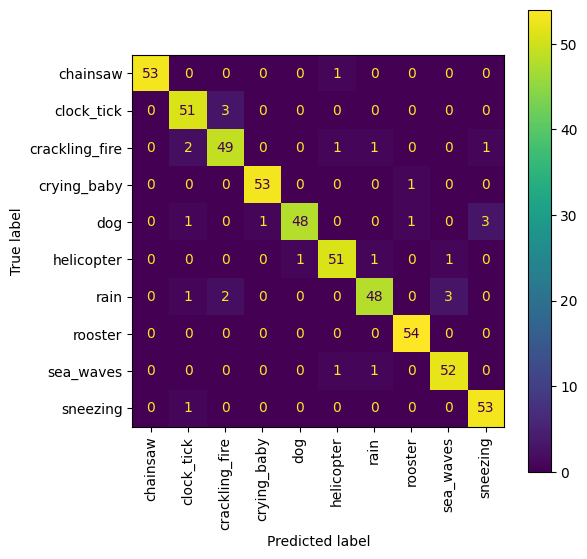

<Figure size 640x480 with 0 Axes>

In [ ]:
r_crnn = confusion_matrix(y_test, y_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=r_crnn, display_labels=mapping)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax)
ax.set_xticklabels(mapping.keys(), rotation='vertical')
plt.show()
plt.savefig('/content/gdrive/MyDrive/ESC-10 material/crnn_mfcc_conf_mat.png')
np.save('/content/gdrive/MyDrive/ESC-10 material/cm_crnn_mfcc.npy', r_crnn)

Check a particular error and find sound

In [ ]:
misclassifications = np.where((y_pred2 == 8) & (y_test == 6))[0]
print(misclassifications)

[ 92 311 529]


In [ ]:
# the model mistakes some rain sounds for sea waves sounds
miscl = X_test[311]
idx = np.where(np.all(X == miscl, axis=(1, 2)))[0][0]
ipd.Audio(new_data[idx], rate=sample_rate)

### Model with spectrogram

In the model below, spectrograms will be used as model input. Specifically, the X will be composed of an array representing the image.

In [ ]:
val_size  = .15
test_size = .15

X_train_spec, X_test_val_spec, y_cat_train, y_cat_test_val = train_test_split(X_spec, y_cat, test_size=val_size+test_size, random_state=42, stratify=y_cat)
X_val_spec, X_test_spec, y_cat_val, y_cat_test = train_test_split(X_test_val_spec, y_cat_test_val, test_size=test_size/(test_size+val_size), random_state=42, stratify=y_cat_test_val)
print(X_train_spec.shape, X_test_spec.shape, X_val_spec.shape, y_cat_train.shape, y_cat_test.shape,  y_cat_val.shape)

(2520, 224, 224, 3) (540, 224, 224, 3) (540, 224, 224, 3) (2520, 10) (540, 10) (540, 10)


In [ ]:
y_train = np.argmax(y_cat_train, axis = 1)
y_val = np.argmax(y_cat_val, axis = 1)
y_test = np.argmax(y_cat_test, axis = 1)

In [ ]:
model4 =  Sequential([
                          layers.Conv2D(64, (4,4), activation = 'relu', padding='valid', strides=(2, 2), input_shape = X_train_spec.shape[1:]),
                          layers.MaxPooling2D(2, padding='valid'),
                          layers.Conv2D(128, (3,3), activation='relu', padding='valid', strides=(2, 2), kernel_regularizer=rg.l2(0.01)),
                          layers.MaxPooling2D(2, padding='valid'),
                          layers.Conv2D(64, (2,2), activation='relu',padding='valid', kernel_regularizer=rg.l2(0.01)),
                          layers.MaxPooling2D(2, padding='valid'),
                          layers.Flatten(),
                          layers.Dense(64, activation='relu'),
                          layers.Dropout(0.4),
                          layers.Dense(10, activation = 'softmax')
])

model4.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'acc')
model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 111, 111, 64)      3136      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 27, 27, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)        

In [ ]:
# Train model
history4 = model4.fit(X_train_spec, y_cat_train, validation_data=(X_val_spec, y_cat_val), batch_size = 64, epochs=80, shuffle=False)

# Evaluate model
score4 = model4.evaluate(X_val_spec, y_cat_val, verbose=0)

# Save model
model4.save('/content/gdrive/MyDrive/models/cnn_spec.h5')
_, keras_file4 = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model4, keras_file4, include_optimizer=False)
print('Saved baseline model to:', keras_file4)

Epoch 1/80
40/40 [==============================] - 4s 48ms/step - loss: 3.0883 - acc: 0.1905 - val_loss: 2.3199 - val_acc: 0.3204
Epoch 2/80
40/40 [==============================] - 1s 29ms/step - loss: 2.1042 - acc: 0.3226 - val_loss: 1.8466 - val_acc: 0.3704
Epoch 3/80
40/40 [==============================] - 1s 27ms/step - loss: 1.7437 - acc: 0.4159 - val_loss: 1.4628 - val_acc: 0.5537
Epoch 4/80
40/40 [==============================] - 1s 27ms/step - loss: 1.4759 - acc: 0.5179 - val_loss: 1.2167 - val_acc: 0.6648
Epoch 5/80
40/40 [==============================] - 1s 28ms/step - loss: 1.2936 - acc: 0.6012 - val_loss: 1.0664 - val_acc: 0.7315
Epoch 6/80
40/40 [==============================] - 1s 28ms/step - loss: 1.1419 - acc: 0.6369 - val_loss: 0.9102 - val_acc: 0.7833
Epoch 7/80
40/40 [==============================] - 1s 28ms/step - loss: 1.0544 - acc: 0.6758 - val_loss: 0.8743 - val_acc: 0.7519
Epoch 8/80
40/40 [==============================] - 1s 28ms/step - loss: 0.9834 - a

<ipython-input-23-563af9654ab3>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs4, train_acc4, 'b', label='Training accuracy', color='darkmagenta')
<ipython-input-23-563af9654ab3>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs4, val_acc4, 'r', label='Validation accuracy', color='tab:orange')


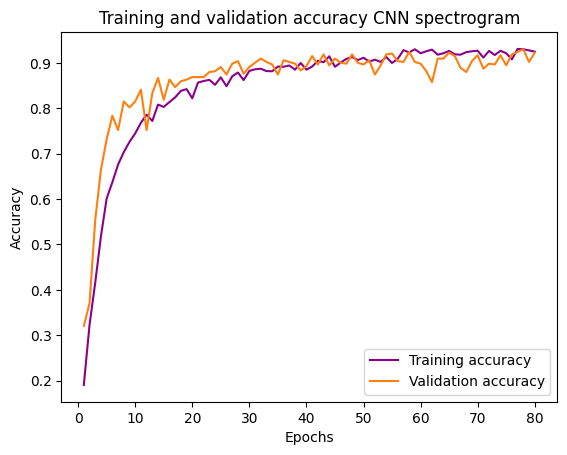

<ipython-input-23-563af9654ab3>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs4, train_loss4, 'b', label='Training loss', color='darkmagenta')
<ipython-input-23-563af9654ab3>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs4, val_loss4, 'r', label='Validation loss', color='tab:orange')


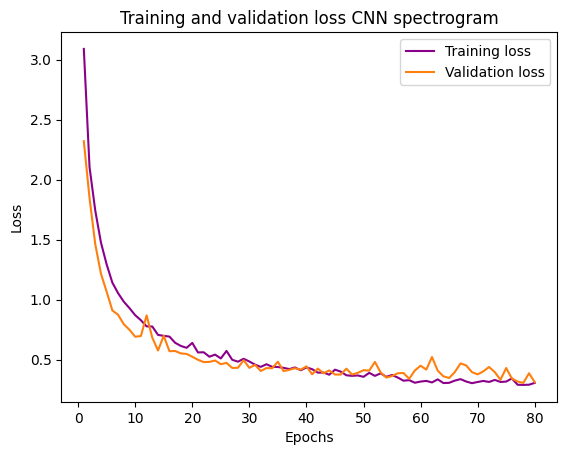

In [ ]:
train_acc4 = history4.history['acc']
train_loss4 = history4.history['loss']
val_acc4 = history4.history['val_acc']
val_loss4 = history4.history['val_loss']

epochs4 = range(1, len(train_acc4) + 1)

plt.plot(epochs4, train_acc4, 'b', label='Training accuracy', color='darkmagenta')
plt.plot(epochs4, val_acc4, 'r', label='Validation accuracy', color='tab:orange')
plt.title('Training and validation accuracy CNN spectrogram')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/gdrive/MyDrive/ESC-10 material/acc_function_CNN_spec.png')
plt.show()

plt.plot(epochs4, train_loss4, 'b', label='Training loss', color='darkmagenta')
plt.plot(epochs4, val_loss4, 'r', label='Validation loss', color='tab:orange')
plt.title('Training and validation loss CNN spectrogram')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/gdrive/MyDrive/ESC-10 material/loss_function_CNN_spec.png')
plt.show()

In [ ]:
# Predict classes for test data
y_pred4 = model4.predict(X_test_spec)

# Convert in the same form
y_pred4 = np.argmax(y_pred4, axis=1)

# Compare predictions to true labels
misclassified_indices = np.where(y_pred4 != y_test)[0]
print(misclassified_indices)

# evaluate the keras model
_, accuracy4 = model4.evaluate(X_test_spec, y_cat_test)
initial_inference_time_4 = measure_inference_time(model4, X_test_spec)

print('Accuracy: %.2f' % (accuracy4*100))
print("Time of inference:", round(initial_inference_time_4, 2))
print("Size of gzipped RNN with MFCC model: %.2f KB" % (get_gzipped_model_size(keras_file4)/ 1024))

17/17 [==============================] - 0s 9ms/step
[  2  13  19  35  38  74 118 165 167 188 210 219 224 241 262 274 292 302
 350 366 372 388 398 402 413 415 427 436 447 455 463 465 479 488 504 508]
17/17 [==============================] - 0s 10ms/step
Accuracy: 93.33
Time of inference: 0.85
Size of gzipped RNN with MFCC model: 957.85 KB


In [ ]:
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.3,
        final_sparsity=0.6,
        begin_step=0,
        end_step=int((len(X_train_spec) // 128) * 10)
    )
}

model_pruned = tfmot.sparsity.keras.prune_low_magnitude(model4, **pruning_params)

In [ ]:
logdir = tempfile.mkdtemp()

callbacks = [tfmot.sparsity.keras.UpdatePruningStep()]

model_pruned.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_pruned.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d_  (None, 111, 111, 64)     6210      
 3 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 55, 55, 64)       1         
 ling2d_3 (PruneLowMagnitude                                     
 )                                                               
                                                                 
 prune_low_magnitude_conv2d_  (None, 27, 27, 128)      147586    
 4 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 13, 13, 128)      1         
 ling2d_4 (PruneLowMagnitude                                     
 )                                                    

In [ ]:
model_pruned.fit(X_train_spec, y_cat_train, epochs=10, batch_size=64, validation_data=(X_val_spec, y_cat_val), callbacks=callbacks)

Epoch 1/10
40/40 [==============================] - 2s 57ms/step - loss: 0.2828 - accuracy: 0.9333 - val_loss: 0.3458 - val_accuracy: 0.9296
Epoch 2/10
40/40 [==============================] - 2s 39ms/step - loss: 0.2555 - accuracy: 0.9448 - val_loss: 0.3954 - val_accuracy: 0.9056
Epoch 3/10
40/40 [==============================] - 1s 31ms/step - loss: 0.3913 - accuracy: 0.8857 - val_loss: 0.3596 - val_accuracy: 0.9056
Epoch 4/10
40/40 [==============================] - 1s 30ms/step - loss: 0.3780 - accuracy: 0.9000 - val_loss: 0.3554 - val_accuracy: 0.9204
Epoch 5/10
40/40 [==============================] - 1s 30ms/step - loss: 0.3357 - accuracy: 0.9071 - val_loss: 0.3168 - val_accuracy: 0.9241
Epoch 6/10
40/40 [==============================] - 1s 30ms/step - loss: 0.3211 - accuracy: 0.9163 - val_loss: 0.3263 - val_accuracy: 0.9074
Epoch 7/10
40/40 [==============================] - 1s 30ms/step - loss: 0.2991 - accuracy: 0.9183 - val_loss: 0.3106 - val_accuracy: 0.9204
Epoch 8/10
40

In [ ]:
_, keras_file_prun = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_pruned, keras_file_prun, include_optimizer=False)
print('Saved baseline model to:', keras_file_prun)

Saved baseline model to: /tmp/tmp1t721l0i.h5


In [ ]:
# evaluate the pruned model
_, accuracy4_prun = model_pruned.evaluate(X_test_spec, y_cat_test)
initial_inference_time_prun = measure_inference_time(model_pruned, X_test_spec)

print('Accuracy: %.2f' % (accuracy4_prun*100))
print("Time of inference:", round(initial_inference_time_prun, 2))
print("Size of gzipped RNN with MFCC model: %.2f KB" % (get_gzipped_model_size(keras_file_prun)/ 1024))

17/17 [==============================] - 0s 9ms/step
Accuracy: 93.33
Time of inference: 0.72
Size of gzipped RNN with MFCC model: 589.68 KB


Check accuracy on test set and all errors of the model

In [ ]:
# Predict classes for test data
y_pred4 = model_pruned.predict(X_test_spec)

# Convert in the same form
y_pred4 = np.argmax(y_pred4, axis=1)

# Compare predictions to true labels
misclassified_indices = np.where(y_pred4 != y_test)[0]
print(misclassified_indices)

17/17 [==============================] - 0s 10ms/step
[  2  13  19  35  38  74 118 165 167 188 210 219 224 241 262 274 292 302
 350 366 372 388 398 402 413 415 427 436 447 455 463 465 479 488 504 508]


In [ ]:
print(classification_report(y_test, y_pred4, target_names=mapping.keys()))

                precision    recall  f1-score   support

      chainsaw       0.87      1.00      0.93        54
    clock_tick       0.91      0.93      0.92        54
crackling_fire       0.89      0.91      0.90        54
   crying_baby       0.91      0.98      0.95        54
           dog       0.98      0.96      0.97        54
    helicopter       0.86      0.93      0.89        54
          rain       1.00      0.78      0.88        54
       rooster       0.98      0.96      0.97        54
     sea_waves       0.96      0.93      0.94        54
      sneezing       1.00      0.96      0.98        54

      accuracy                           0.93       540
     macro avg       0.94      0.93      0.93       540
  weighted avg       0.94      0.93      0.93       540



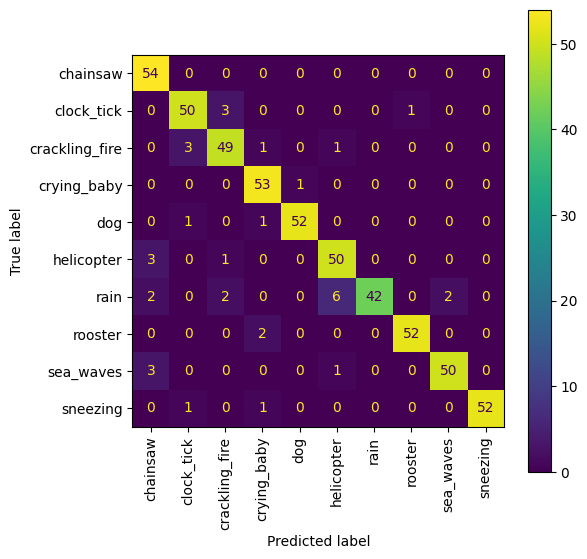

<Figure size 640x480 with 0 Axes>

In [ ]:
r_cnn_spec = confusion_matrix(y_test, y_pred4)
disp = ConfusionMatrixDisplay(confusion_matrix=r_cnn_spec, display_labels=mapping)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax)
ax.set_xticklabels(mapping.keys(), rotation='vertical')
plt.show()
plt.savefig('/content/gdrive/MyDrive/ESC-10 material/cnn_spec_prun_conf_mat.png')
np.save('/content/gdrive/MyDrive/ESC-10 material/cm_cnn_spec_prun.npy', r_cnn_spec)

### Paper model

At this point of the modeling it is important to compare it with an already existing model, both from an architecture and performance point of view.

The reference paper chosen is:

"*Environmental sound classification using a regularized deep convolutional neural network with data augmentation*" (Mushtaq, Su)

The paper was chosen because it provides a clear exposition of the model and the results on the dataset we have chosen (ESC-10).

Below, the visual structure of the network.




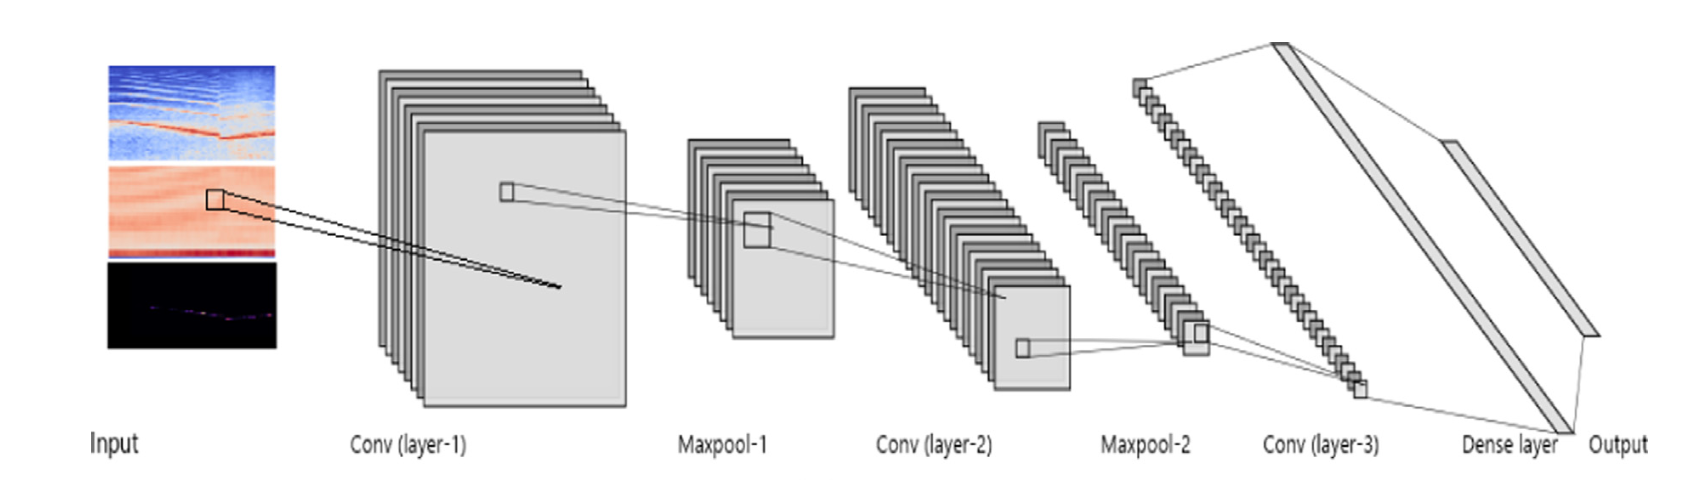

This approach is directly comparable with our previous MFCC model.

In [ ]:
model =  Sequential([
                          layers.Conv2D(24, (5,5), activation = 'relu', padding='same', input_shape = X_train.shape[1:],kernel_regularizer=rg.l2(0.001)),
                          layers.MaxPooling2D(pool_size=(3, 3), strides=(3, 3), padding='same'),
                          layers.Conv2D(36, (4,4), activation='relu', kernel_regularizer=rg.l2(0.001)),
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Conv2D(48, (3,3), activation='relu'),
                          layers.Flatten(),
                          layers.Dense(60, activation='relu'),
                          layers.Dropout(0.5),
                          layers.Dense(10, activation = 'softmax')
])


# compile the model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 60, 216, 24)       1824      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 20, 72, 24)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 17, 69, 36)        13860     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 9, 35, 36)        0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 7, 33, 48)         15600     
                                                                 
 flatten_7 (Flatten)         (None, 11088)            

In [ ]:
# Train model
history5 = model.fit(X_train, y_cat_train, batch_size=32, epochs=100, validation_data=(X_val, y_cat_val), shuffle=False)

# Evaluate model
score5 = model.evaluate(X_val, y_cat_val, verbose=0)

# Save model
model.save('/content/gdrive/MyDrive/models/cnn_mfcc.h5')
_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

Epoch 1/100
79/79 [==============================] - 4s 15ms/step - loss: 2.0083 - accuracy: 0.3282 - val_loss: 1.4398 - val_accuracy: 0.4685
Epoch 2/100
79/79 [==============================] - 1s 9ms/step - loss: 1.3320 - accuracy: 0.5313 - val_loss: 0.9852 - val_accuracy: 0.7130
Epoch 3/100
79/79 [==============================] - 1s 8ms/step - loss: 1.0714 - accuracy: 0.6409 - val_loss: 0.7107 - val_accuracy: 0.8000
Epoch 4/100
79/79 [==============================] - 1s 8ms/step - loss: 0.9499 - accuracy: 0.6857 - val_loss: 0.6186 - val_accuracy: 0.8296
Epoch 5/100
79/79 [==============================] - 1s 8ms/step - loss: 0.7898 - accuracy: 0.7405 - val_loss: 0.4868 - val_accuracy: 0.8722
Epoch 6/100
79/79 [==============================] - 1s 8ms/step - loss: 0.6877 - accuracy: 0.7706 - val_loss: 0.5487 - val_accuracy: 0.8370
Epoch 7/100
79/79 [==============================] - 1s 8ms/step - loss: 0.6367 - accuracy: 0.7841 - val_loss: 0.4229 - val_accuracy: 0.8741
Epoch 8/100


<ipython-input-105-7be962f3d892>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs5, train_acc5, 'b', label='Training accuracy', color='darkmagenta')
<ipython-input-105-7be962f3d892>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs5, val_acc5, 'r', label='Validation accuracy', color='tab:orange')


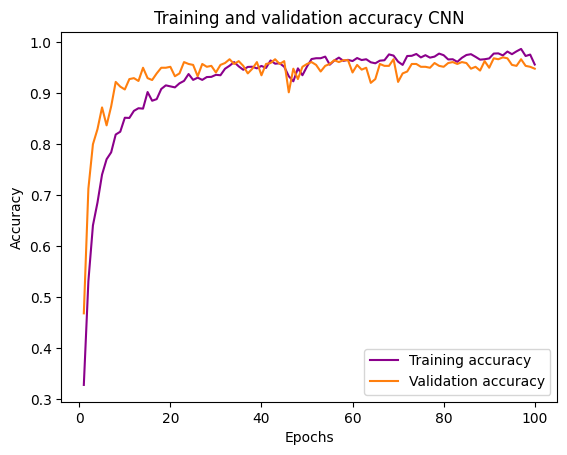

<ipython-input-105-7be962f3d892>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs5, train_loss5, 'b', label='Training loss', color='darkmagenta')
<ipython-input-105-7be962f3d892>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs5, val_loss5, 'r', label='Validation loss', color='tab:orange')


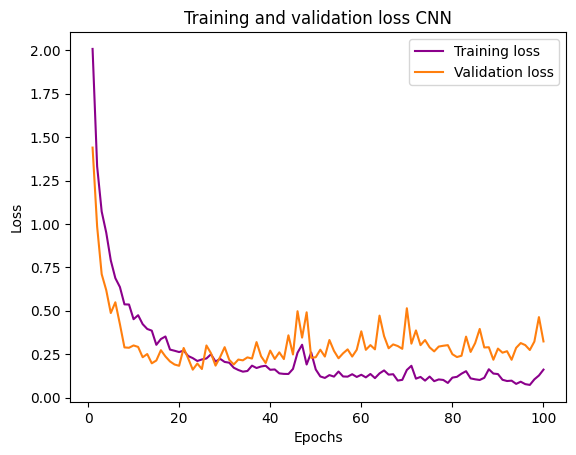

In [ ]:
train_acc5 = history5.history['accuracy']
train_loss5 = history5.history['loss']
val_acc5 = history5.history['val_accuracy']
val_loss5 = history5.history['val_loss']

epochs5 = range(1, len(train_acc5) + 1)

plt.plot(epochs5, train_acc5, 'b', label='Training accuracy', color='darkmagenta')
plt.plot(epochs5, val_acc5, 'r', label='Validation accuracy', color='tab:orange')
plt.title('Training and validation accuracy CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/gdrive/MyDrive/ESC-10 material/acc_function_paper.png')
plt.show()

plt.plot(epochs5, train_loss5, 'b', label='Training loss', color='darkmagenta')
plt.plot(epochs5, val_loss5, 'r', label='Validation loss', color='tab:orange')
plt.title('Training and validation loss CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/gdrive/MyDrive/ESC-10 material/loss_function_paper.png')
plt.show()

In [ ]:
# Predict classes for test data
y_pred5 = model.predict(X_test)

# Convert in the same form
y_pred5 = np.argmax(y_pred5, axis=1)

# Compare predictions to true labels
misclassified_indices = np.where(y_pred5 != y_test)[0]
print(misclassified_indices)

# evaluate the keras model
_, accuracy5 = model.evaluate(X_test, y_cat_test)
initial_inference_time_5 = measure_inference_time(model, X_test)

print('Accuracy: %.2f' % (accuracy5*100))
print("Time of inference:", round(initial_inference_time_5, 2))
print("Size of gzipped RNN with MFCC model: %.2f KB" % (get_gzipped_model_size(keras_file)/ 1024))

17/17 [==============================] - 0s 4ms/step
[  6  59  74  84 104 116 137 150 153 165 167 181 204 221 224 232 233 236
 241 244 259 272 274 292 342 346 369 392 397 415 427 446 447 455 461 465
 524 530]
17/17 [==============================] - 0s 3ms/step
Accuracy: 92.96
Time of inference: 0.36
Size of gzipped RNN with MFCC model: 2545.88 KB


In [ ]:
print(classification_report(y_test, y_pred5, target_names=mapping.keys()))

                precision    recall  f1-score   support

      chainsaw       0.95      1.00      0.97        54
    clock_tick       0.84      1.00      0.92        54
crackling_fire       1.00      0.78      0.88        54
   crying_baby       0.98      0.96      0.97        54
           dog       0.94      0.91      0.92        54
    helicopter       0.88      0.85      0.87        54
          rain       0.83      0.93      0.88        54
       rooster       0.96      1.00      0.98        54
     sea_waves       1.00      0.94      0.97        54
      sneezing       0.94      0.93      0.93        54

      accuracy                           0.93       540
     macro avg       0.93      0.93      0.93       540
  weighted avg       0.93      0.93      0.93       540



The paper model is of less complexity: it has fewer parameters and fewer layers. It has a higher level of overfitting than our model and a shorter execution time. The accuracy achieved is slightly lower than that achieved by our model.

## RESULTS

In [ ]:
r_cnn = np.load('/content/gdrive/MyDrive/ESC-10 material/cm_cnn_mfcc.npy')
r_rnn = np.load('/content/gdrive/MyDrive/ESC-10 material/cm_rnn_mfcc.npy')
r_crnn = np.load('/content/gdrive/MyDrive/ESC-10 material/cm_crnn_mfcc.npy')
r_cnn_spec = np.load('/content/gdrive/MyDrive/ESC-10 material/cm_cnn_spec_prun.npy')

class_acc_mfcc_cnn = np.round((np.diag(r_cnn) / np.sum(r_cnn, axis=1)), 2)
class_acc_mfcc_rnn = np.round((np.diag(r_rnn) / np.sum(r_rnn, axis=1)), 2)
class_acc_mfcc_crnn = np.round((np.diag(r_crnn) / np.sum(r_crnn, axis=1)), 2)
class_acc_spec_cnn = np.round((np.diag(r_cnn_spec) / np.sum(r_cnn_spec, axis=1)), 2)

In [ ]:
acc_list = [class_acc_mfcc_cnn, class_acc_mfcc_rnn, class_acc_mfcc_crnn, class_acc_spec_cnn]
indexes = ['CNN_mfcc', 'RNN_mfcc', 'CRNN_mfcc', 'CNN_spec']

acc_df = pd.DataFrame(acc_list, columns=mapping.keys(), index=indexes)
acc_df

chainsaw  clock_tick  crackling_fire  crying_baby   dog  \
CNN_mfcc       0.96        0.91            0.91         1.00  0.93   
RNN_mfcc       0.98        0.94            0.89         1.00  0.96   
CRNN_mfcc      0.98        0.94            0.91         0.98  0.89   
CNN_spec       1.00        0.93            0.91         0.98  0.96   

           helicopter  rain  rooster  sea_waves  sneezing  
CNN_mfcc         0.94  0.80     1.00       0.98      0.98  
RNN_mfcc         0.98  0.93     1.00       0.96      0.94  
CRNN_mfcc        0.94  0.89     1.00       0.96      0.98  
CNN_spec         0.93  0.78     0.96       0.93      0.96

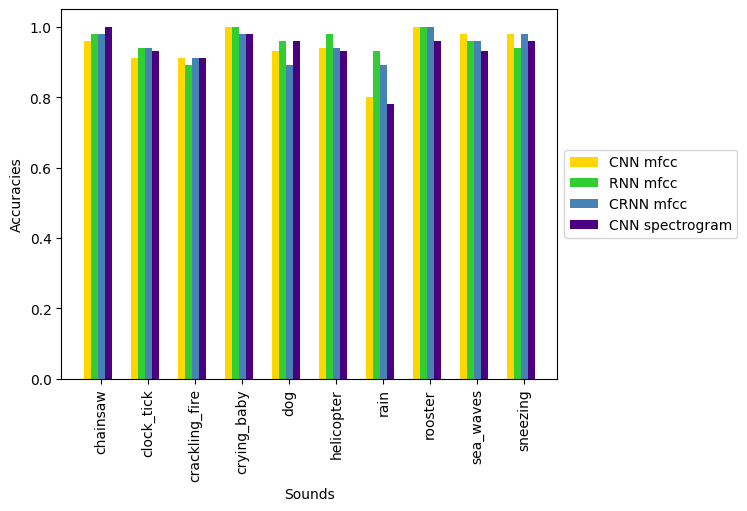

<Figure size 640x480 with 0 Axes>

In [ ]:
x = np.arange(10)
class_acc_mfcc_cnn_f = list(np.around(np.array(class_acc_mfcc_cnn),2))
class_acc_mfcc_rnn_f = list(np.around(np.array(class_acc_mfcc_rnn),2))
class_acc_mfcc_crnn_f = list(np.around(np.array(class_acc_mfcc_crnn),2))
class_acc_spec_cnn_f = list(np.around(np.array(class_acc_spec_cnn), 2))

categories_f_plot = list(mapping.keys())
width = 0.15

plt.bar(x - 0.3, class_acc_mfcc_cnn_f, width, color="gold")
plt.bar(x - 0.15, class_acc_mfcc_rnn_f, width, color="limegreen")
plt.bar(x, class_acc_mfcc_crnn_f, width, color="steelblue")
plt.bar(x + 0.15, class_acc_spec_cnn_f, width, color="indigo")
plt.xticks(x, categories_f_plot, rotation=90)

plt.xlabel("Sounds")
plt.ylabel("Accuracies")
plt.legend(["CNN mfcc", "RNN mfcc", "CRNN mfcc", "CNN spectrogram"], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
plt.savefig('/content/gdrive/MyDrive/ESC-10 material/comparison_hist.png')